# 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data), '테스트용 리뷰 개수 :',len(test_data))

## 데이터 전처리

In [ ]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
print('총 샘플의 수 :',len(train_data))

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.isnull().values.any())

In [ ]:
print(train_data.isnull().sum())

In [ ]:
train_data.loc[train_data.document.isnull()]

In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

In [ ]:
print(len(train_data))

In [ ]:
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

In [ ]:
train_data.loc[train_data.document.isnull()][:5]

In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

### Test Set 전처리

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

## 토큰화

In [6]:
# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
from konlpy.tag import Okt

In [5]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

In [ ]:
print(X_train[:3])

In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

In [ ]:
import pickle

with open("X_train.pkl","wb") as f:
    pickle.dump(X_train, f)
    
with open("X_test.pkl","wb") as f:
    pickle.dump(X_test, f)

In [3]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

np.save('y_train', y_train)
np.save('y_test', y_test)

NameError: name 'np' is not defined

## LOAD DATA

In [9]:
import pickle

In [10]:
with open("X_train.pkl","rb") as f:
    X_train = pickle.load(f)
    
with open("X_test.pkl","rb") as f:
    X_test = pickle.load(f)

In [11]:
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

## 정수 인코딩

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


# 빈 샘플들을 제거
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904
단어 집합의 크기 : 19416
145162
144931


/Users/kunwooshin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


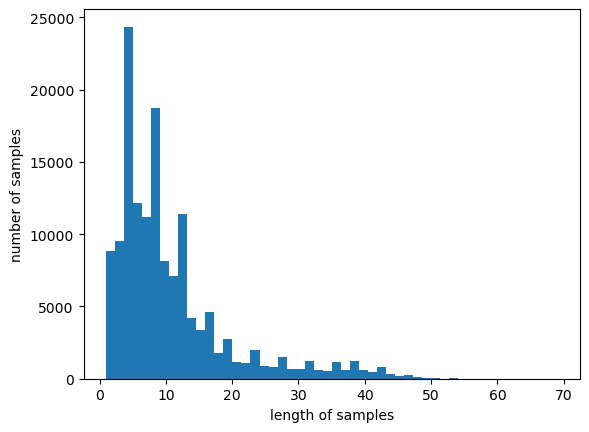

In [13]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [15]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(filepath='/Users/kunwooshin/movie_scraping/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [16]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Metal device set to: Apple M1


2022-12-10 09:43:48.144637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 09:43:48.144858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-10 09:43:48.777230: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 09:43:49.042881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-10 09:43:49.118766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1527/1527 [==============================] - 19s 12ms/step - loss: 0.3419 - acc: 0.8576

 테스트 정확도: 0.8576


In [17]:
def sentiment_predict(new_sentence):
    
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    return score

In [18]:
sentiment_predict('\n\n최고!! 최고!!! 진짜 한국영화중에 제일 재밌었음')

1/1 [==============================] - ETA: 0s

2022-12-10 09:44:11.603495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-10 09:44:11.660241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 425ms/step


0.9974331259727478

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
review1 = pd.read_excel('베테랑_review.xlsx')

In [ ]:
pos = 0
neg = 0
pos_cnt = 0
neg_cnt = 0

for elem in review1['review']:
    new_sentence = elem.replace('_x000D_','').replace('관람객','').replace('스포일러가 포함된 감상평입니다. 감상평 보기','')
    score = sentiment_predict(new_sentence)
    if(score > 0.5):
        pos += (score-0.5)
        pos_cnt += 1
    else:
        neg += score
        neg_cnt += 1
        
print('긍정평균(0.5만점):',pos/pos_cnt,'부정평균(0.5만점):',neg/neg_cnt)

In [ ]:
review2 = pd.read_excel('암살_review.xlsx')

In [ ]:
pos = 0
neg = 0
pos_cnt = 0
neg_cnt = 0

for elem in review2['review']:
    new_sentence = elem.replace('_x000D_','').replace('관람객','').replace('스포일러가 포함된 감상평입니다. 감상평 보기','')
    score = sentiment_predict(new_sentence)
    if(score > 0.5):
        pos += (score-0.5)
        pos_cnt += 1
    else:
        neg += score
        neg_cnt += 1
        
print('긍정평균(0.5만점):',pos/pos_cnt,'부정평균(0.5만점):',neg/neg_cnt)
    

In [ ]:
review20 = pd.read_excel('스물_review.xlsx')

In [ ]:
pos = 0
neg = 0
pos_cnt = 0
neg_cnt = 0

for elem in review20['review']:
    new_sentence = elem.replace('_x000D_','').replace('관람객','').replace('스포일러가 포함된 감상평입니다. 감상평 보기','')
    score = sentiment_predict(new_sentence)
    if(score > 0.5):
        pos += (score-0.5)
        pos_cnt += 1
    else:
        neg += score
        neg_cnt += 1
        
print('긍정평균(0.5만점):',pos/pos_cnt,'부정평균(0.5만점):',neg/neg_cnt)

In [ ]:
pos = 0
neg = 0
pos_cnt = 0
neg_cnt = 0

for elem in review1['review']:
    new_sentence = elem.replace('_x000D_','').replace('관람객','').replace('스포일러가 포함된 감상평입니다. 감상평 보기','')
    score = sentiment_predict(new_sentence)
    if(score > 0.5):
        pos += (score-0.5)
        pos_cnt += 1
    else:
        neg += score
        neg_cnt += 1
        
print('긍정평균(0.5만점):',pos/pos_cnt,'부정평균(0.5만점):',neg/neg_cnt)